<a href="https://colab.research.google.com/github/sakharovs/DZ_1/blob/master/Sakharov_VAE_v_001.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import sys
import tensorflow as tf
print(tf.__version__)
print(sys.version)

2.12.0
3.10.9 | packaged by Anaconda, Inc. | (main, Mar  1 2023, 18:18:15) [MSC v.1916 64 bit (AMD64)]


In [ ]:
# Импорт необходимых библиотек
import numpy as np
import random
import pandas as pd
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape, Input, Conv2DTranspose, concatenate, Concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization, Lambda, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils
from tensorflow.keras.models import load_model
from tensorflow.keras import Model
from tensorflow.keras.preprocessing import image
from tensorflow import keras
import keras
import keras.backend as K
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error
import gdown
import os
import time
import pandas as pd
from PIL import Image
import cv2
import matplotlib.pyplot as plt 
import os 
from google.colab import drive 
import time, random
import seaborn as sns
%matplotlib inline

In [ ]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# функция проверки наличия папки по указанному адресу

def check_folder(folder_name):
  if os.path.exists(folder_name):
    print('Ok')
  else:
    os.makedirs(folder_name)
    print(f'Folder {folder_name} created.')

In [ ]:
!unzip -qo '/content/drive/MyDrive/УИИ/БД/processed_extended_dataset_3.zip' -d /content/drive/MyDrive/УИИ/БД/DB/Selector

In [ ]:
IMAGE_PATH = '/content/drive/MyDrive/УИИ/БД/DB/Selector/processed extended dataset 3/' 

In [ ]:
CLASS_LIST = sorted(os.listdir(IMAGE_PATH)) #создание списка классов
CLASS_COUNT = len(CLASS_LIST) # определение кол-ва классов
#print(CLASS_COUNT)

In [ ]:
data_files = []   #список путей к файлам картинок
data_labels = []  #список меток классов, соотвествующих файлам

for class_label in range(CLASS_COUNT):    # Для каждой метки из CLASS_COUNT
  class_name = CLASS_LIST[class_label]    # Присваиваем имя класса class_name из списка CLASS_LIST позиции class_label
  class_path = IMAGE_PATH + class_name    # присваиваем путь к метке класса
  class_files = os.listdir(class_path)    # находим имя файла
  print(f'Размер класса {class_name} составляет {len(class_files)} изображений') # Выводим список классов с кол-вом изображений в каждом

  data_files += [f'{class_path}/{file_name}' for file_name in class_files] # Добавляем файлы в список
  data_labels +=[class_label] * len(class_files) # Добавляем метки в список

print('Общий размер базы: ', len(data_labels))


Размер класса dress  business составляет 928 изображений
Размер класса dress casual составляет 805 изображений
Размер класса dress homemade составляет 975 изображений
Размер класса dress solemn составляет 993 изображений
Размер класса shirt men составляет 2849 изображений
Размер класса shirt women составляет 1033 изображений
Размер класса sportswear men составляет 884 изображений
Размер класса sportswear women составляет 1008 изображений
Размер класса t-shirt men составляет 1069 изображений
Размер класса t-shirt women составляет 1171 изображений
Размер класса trousers men составляет 1780 изображений
Размер класса trousers women составляет 986 изображений
Общий размер базы:  14481


In [ ]:
IMG_WIDTH = 64
IMG_HEIGHT = 64

In [ ]:
data_images = []

for file_name in data_files:
  img = Image.open(file_name).resize((IMG_WIDTH, IMG_HEIGHT)).convert('L')
  img_np = np.array(img)
  data_images.append(img_np)

x_data = np.array(data_images)
y_data = np.array(data_labels)

print(f'В массив собрано {len(data_images)} изображений размером {img_np.shape}')
print(f'Общий размер массива данных {x_data.shape}')
print(f'Общий размер массива меток {y_data.shape}')

В массив собрано 14481 изображений размером (64, 64)
Общий размер массива данных (14481, 64, 64)
Общий размер массива меток (14481,)


In [ ]:
check_folder('/content/drive/MyDrive/УИИ/БД/DB/x_data')
np.save('/content/drive/MyDrive/УИИ/БД/DB/x_data', x_data)
np.save('/content/drive/MyDrive/УИИ/БД/DB/y_data', y_data)

Ok


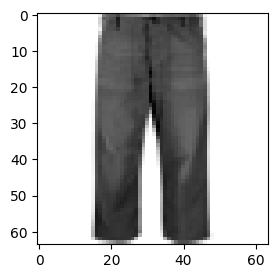

In [ ]:
fig, axs = plt.subplots(1,1, figsize=(25, 3))
axs.imshow(Image.fromarray(x_data[14400]), cmap='gray')
plt.show()

In [ ]:
x_data = np.load('/content/drive/MyDrive/УИИ/БД/DB/x_data.npy')
y_data = np.load('/content/drive/MyDrive/УИИ/БД/DB/y_data.npy')

In [ ]:
x_data = x_data.reshape(-1, IMG_HEIGHT, IMG_WIDTH, 1) # Что означает "минус один"?
x_data = x_data.astype('float32')                     # Зачем приводим к float32?
x_data /= 255

In [ ]:
x_data.shape

(14481, 64, 64, 1)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_data,
                                                    y_data,
                                                    test_size = 0.2,
                                                    shuffle =True,
                                                    random_state = 3)

In [ ]:
x_train.shape

(11584, 64, 64, 1)

In [ ]:
def baseAutoencoder(shape=(112,80,3)):
  img_input = Input((shape))
  x = Conv2D(32, (3,3), padding='same', activation='relu')(img_input)
  x = BatchNormalization()(x)
  x = Conv2D(32, (3,3), padding='same', activation='relu')(x)
  x = BatchNormalization()(x)
  x = MaxPooling2D()(x)

  x = Conv2D(64, (3,3), padding='same', activation='relu')(x)
  x = BatchNormalization()(x)
  x = Conv2D(64, (3,3), padding='same', activation='relu')(x)
  x = BatchNormalization()(x)
  x = MaxPooling2D()(x)

  x = Conv2DTranspose(64,(2,2), strides=(2,2), padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(64, (3,3), padding='same', activation='relu')(x)
  x = BatchNormalization()(x)
  x = Conv2D(64, (3,3), padding='same', activation='relu')(x)
  x = BatchNormalization()(x)
  
  x = Conv2DTranspose(32,(2,2), strides=(2,2), padding='same', activation='relu')(x)
  x = BatchNormalization()(x)
  x = Conv2D(64, (3,3), padding='same', activation='relu')(x)
  x = BatchNormalization()(x)
  x = Conv2D(64, (3,3), padding='same', activation='relu')(x)
  x = BatchNormalization()(x)

  x = Conv2D(shape[-1], (3,3), activation='sigmoid', padding='same')(x)

  model = Model(img_input, x)
  model.compile(optimizer=Adam (learning_rate=0.0001),
                loss='mean_squared_error')
  return model

In [ ]:
def plotImages(xTrain, pred, shape=(112,80)):
  n = 5 # Qty of pictures for displaing
  plt.figure(figsize=(14,7))
  for i in range(n):
    index = np.random.randint(0, pred.shape[0])
    ax = plt.subplot(2, n, i+1)
    plt.imshow(xTrain[index].reshape(shape))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(pred[index].reshape(shape))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

In [ ]:
model = baseAutoencoder((64,64,1))

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 64, 64, 32)        320       
                                                                 
 batch_normalization_10 (Bat  (None, 64, 64, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_10 (Conv2D)          (None, 64, 64, 32)        9248      
                                                                 
 batch_normalization_11 (Bat  (None, 64, 64, 32)       128       
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 32)       0   

In [ ]:
history = model.fit(x_train, x_train, epochs=40, batch_size=128, validation_data = (x_test, x_test))

Epoch 1/40
 5/91 [>.............................] - ETA: 18:30 - loss: 0.2891

KeyboardInterrupt: ignored

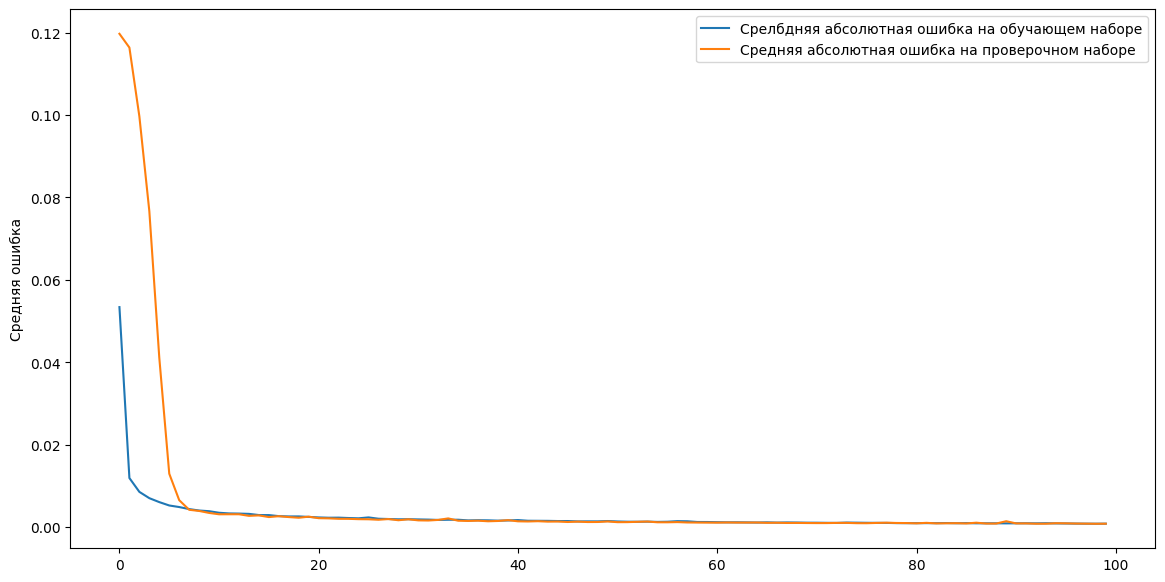

In [ ]:
from IPython.core.interactiveshell import validate
plt.figure(figsize=(14,7))
plt.plot(history.history['loss'],
         label='Срелбдняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'],
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [ ]:
predTest = model.predict(x_test)
predTest = predTest*255
predTest = predTest.astype('uint8')

91/91 [==============================] - 2s 13ms/step


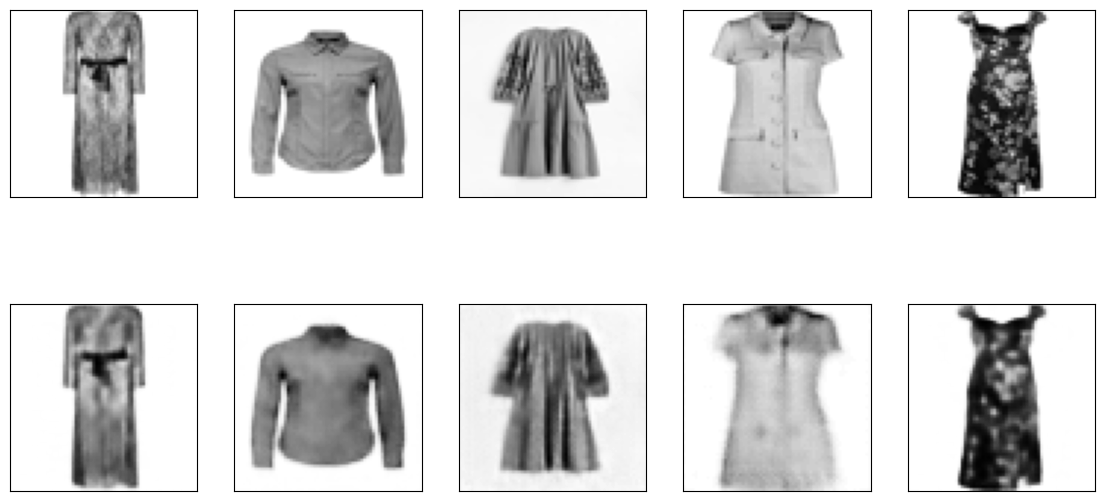

In [ ]:
plotImages(x_test, predTest, shape=(64,64))

In [ ]:
predTrain = model.predict(x_train)
predTrain *=255
predTrain = predTrain.astype('uint8')

364/364 [==============================] - 4s 10ms/step


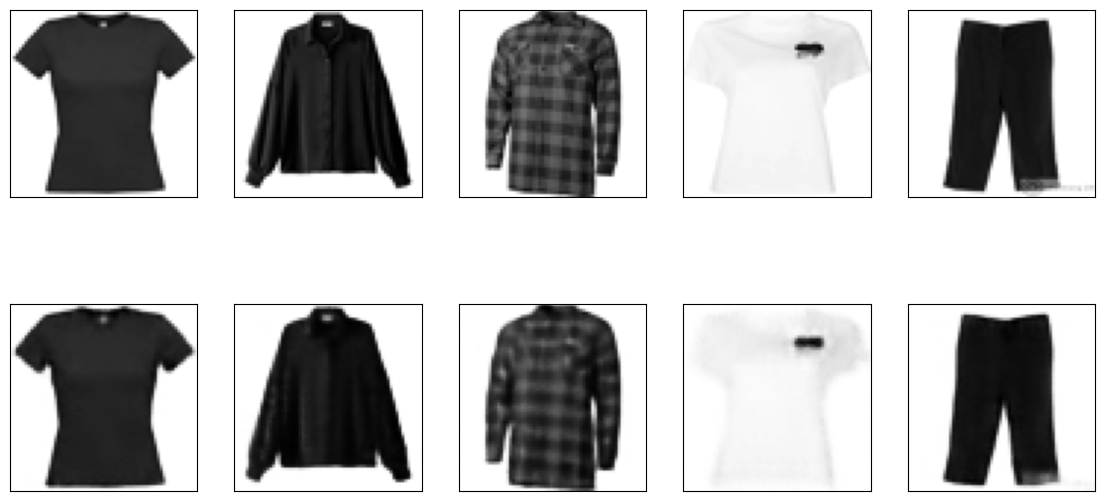

In [ ]:
plotImages(x_train, predTrain, shape=(64,64))

In [ ]:
def getMSE(x1,x2):
  x1 = x1.flatten()
  x2 = x2.flatten()
  delta = x1-x2
  return sum(delta**2)/len(delta)

In [ ]:
err1 = [getMSE(x_train[i], predTrain[i]/255) for i in range (len(predTrain))]
err2 = [getMSE(x_test[i], predTest[i]/255) for i in range (len(predTest))]
print("Средняя ошибка на обучающем наборе :", sum(err1) / x_train.shape[0])
print("Средняя ошибка на тестовом наборе :", sum(err2) /x_test.shape[0] )

Средняя ошибка на обучающем наборе : 0.0008435272964734198
Средняя ошибка на тестовом наборе : 0.0008636218768111798


In [ ]:
model.save('Sakharov_VAE_v.001.h5')